In [1]:
import sys
sys.path.append("..")

In [17]:
import umap
import operator
import shap
from xgboost import XGBClassifier
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from ksvd import ApproximateKSVD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from comon import *
from plots_report import plot_metrics

In [18]:
ocean = 'BarentsSea'

In [19]:
files = ['CZ1.txt', 'CZ2.txt', 'CZ3.txt', 'CZ4.txt','CZ5.txt', 'CZ6.txt',
         'CZ7.txt','CZ8.txt','CZ9.txt','CZ10.txt', 'CZ11.txt','CZ12.txt']

CZ = []
for file in files:
    with open('{0}/{1}'.format(ocean, file), 'r') as f:
        line = f.readlines()
        cz=creatMas(line)
    CZ.append(cz)
    
_, N_cord = cz.shape

with open('{}/zs.txt'.format(ocean), 'r') as f:
    line = f.readlines()
    line.remove(line[N_cord])
zs = [-int(a) for a in line]

In [20]:
winter_index, summer_index = [12, 1, 2], [6, 7, 8]
X, Y = creat_win_sum_data(CZ, winter_index, summer_index, N=200)
X = pd.DataFrame(X, columns=zs)
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=0.2, stratify=Y, random_state=0)

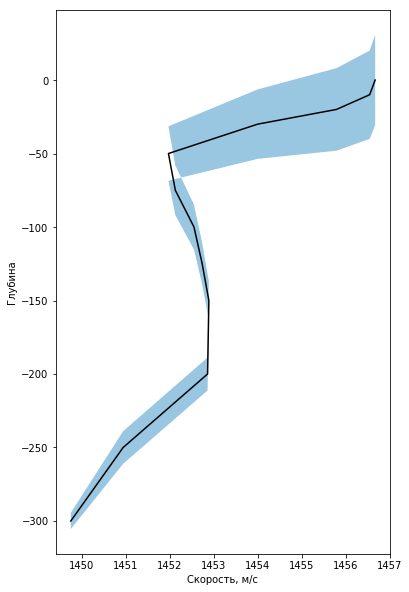

In [21]:
x  = np.array(X_train)
x_std = np.std(x, axis=0)
x_mean = np.mean(x, axis=0)
plt.figure(figsize=(6,10))
plt.plot(x_mean,zs, 'k')
plt.ylabel('Глубина')
plt.xlabel('Скорость, м/с')
plt.fill_between(x_mean, zs - 3*x_std, zs + 3*x_std, alpha=0.4)
plt.show()

**количество кластеров**

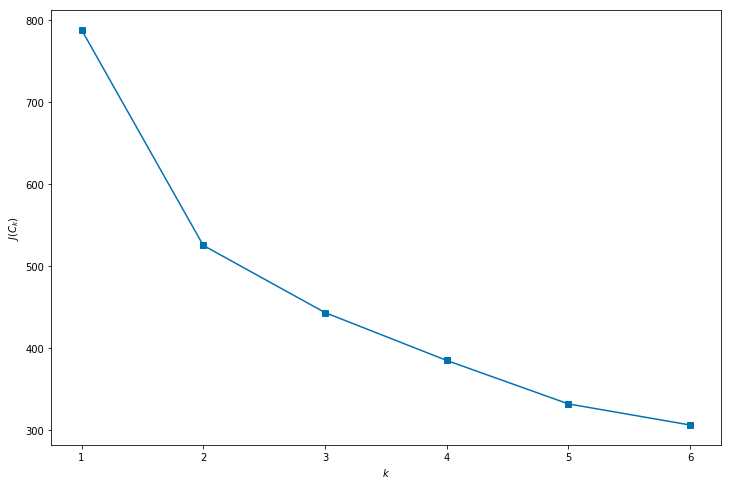

In [22]:
plt.figure(figsize=(12,8))
inertia = []
for k in range(1, 7):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 7), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');
plt.show()

## LogisticRegression

In [34]:
clf = LogisticRegression()
param = [0.01, 0.1, 1, 10, 20, 30, 50, 70, 100, 120, 130]
param_grid = { 'C': param }

grd = GridSearchCV(clf, param_grid, cv=5,
                      return_train_score=False)
grd.fit(X_train, y_train)
grd.best_params_

{'C': 10}

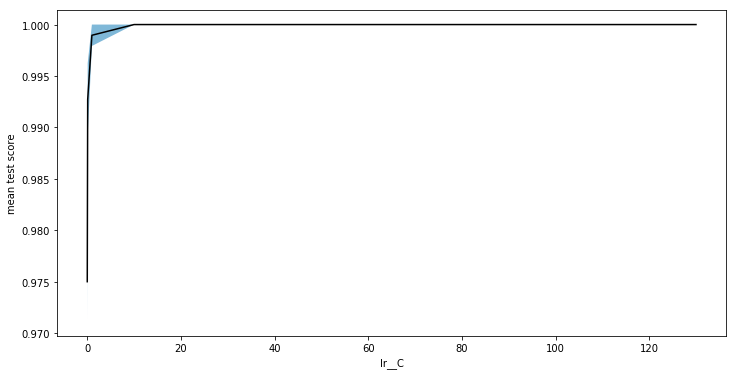

In [36]:
mean_scor = grd.cv_results_['mean_test_score']
std_score = grd.cv_results_['std_test_score']
plt.figure(figsize=(12,6))
plt.plot(param, grd.cv_results_['mean_test_score'], c='k')
plt.fill_between(param, mean_scor - std_score/2, mean_scor + std_score/2, alpha=0.5)
plt.xlabel('lr__C')
plt.ylabel('mean test score')
plt.show()

Accuracy на тренировочных данных: 1.0
Accuracy на тестовых данных: 0.9958333333333333


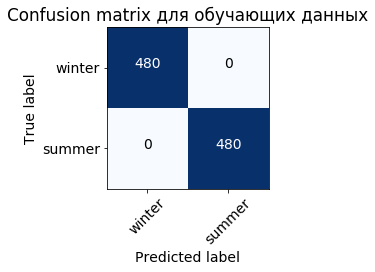

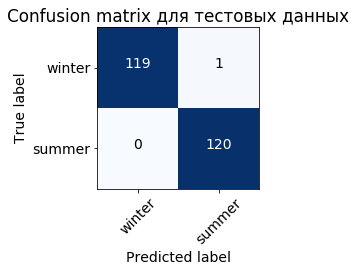

In [12]:
clf = LogisticRegression(C=20)
clf.fit(X_train, y_train)
print_metrics(clf, X_train, X_test, y_train, y_test)

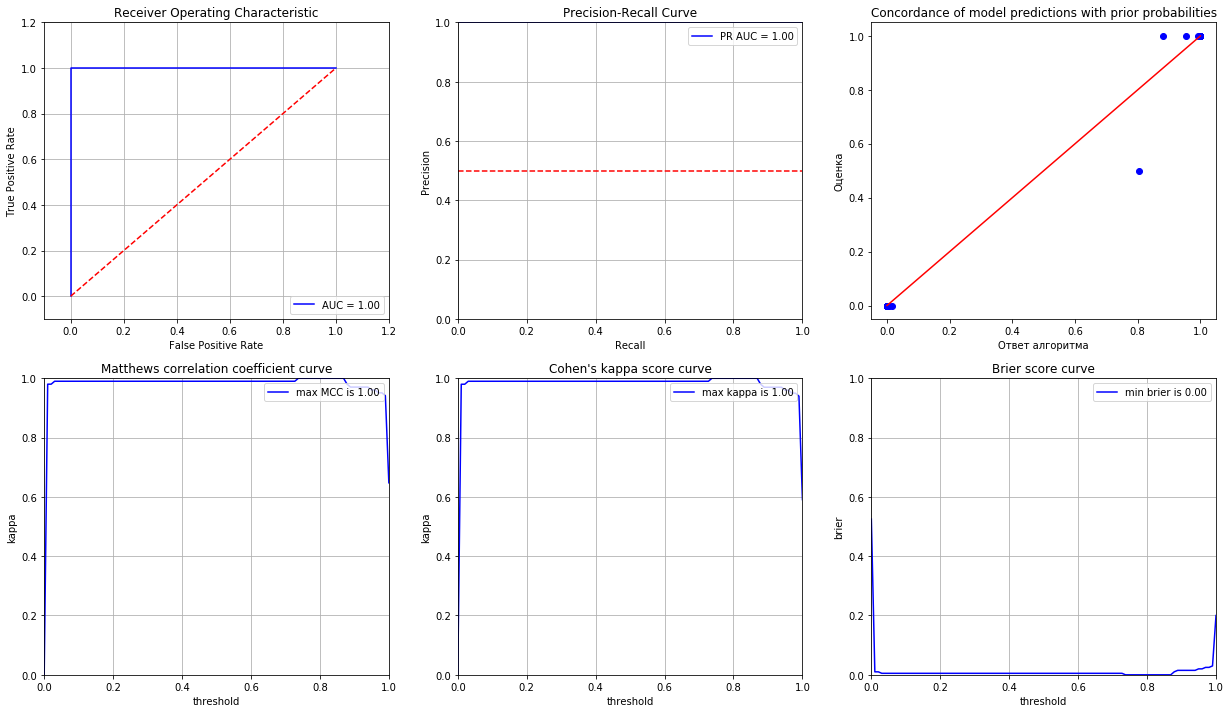

The rmse of model's prediction is: 0.0545
The Gini of model's prediction is: 1.0000
The ROC AUC of model's prediction is: 1.0000
The PR AUC of model's prediction is: 1.0000
Max Cohen's kappa is 1.000 with threshold = 0.74
Max Matthews correlation coefficient is 1.000 with threshold = 0.74
Min Brier score is 0.000 with threshold = 0.74


In [38]:
pr_prob = clf.predict_proba(X_test)[:,1]
N = len(y_test)
M = 100
n = int(N/M)
plot_metrics(np.array(y_test[:n*M]), pr_prob[:n*M],n=M)

**Важность координат**

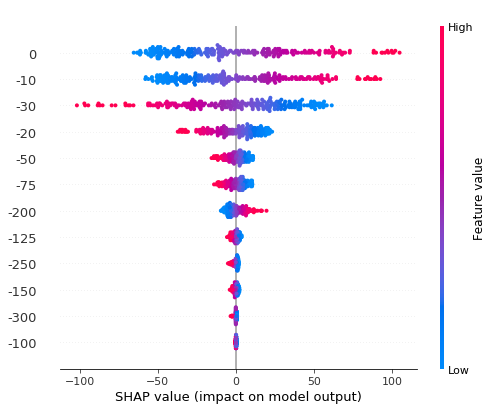

In [39]:
explainer = shap.LinearExplainer(clf, X_test)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

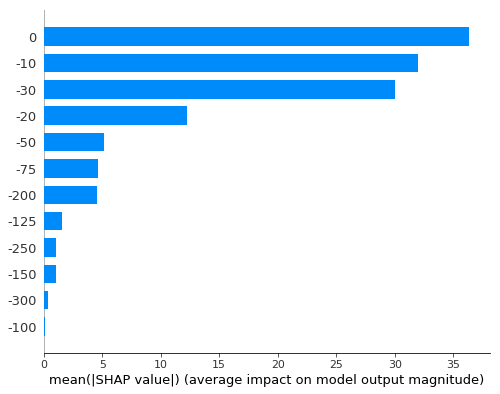

In [40]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

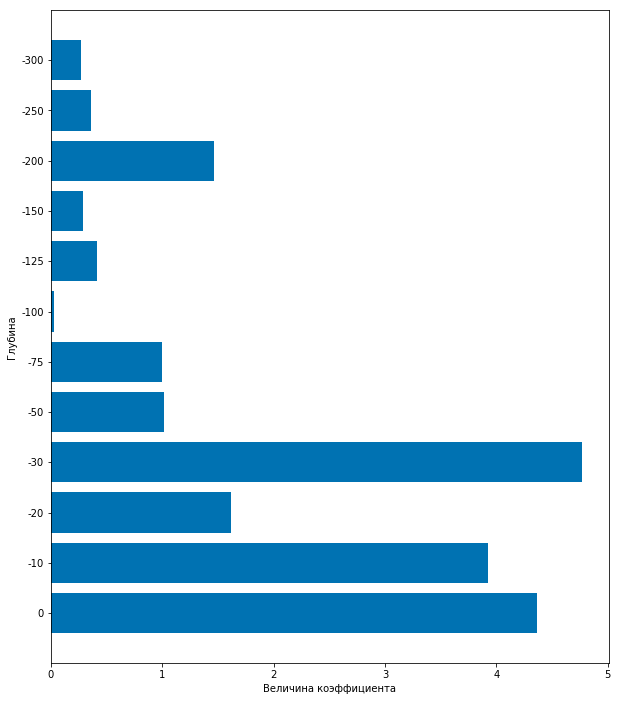

In [41]:
x = range(1,N_cord+1)
y = list(map(abs,clf.coef_[0]))
plt.figure(figsize=(10,12))
plt.barh(x, y)
plt.xlabel('Величина коэффициента')
plt.ylabel('Глубина')
plt.yticks(x,list(map(str,zs)))
plt.show()

## LogisticRegression + StandardScaler

In [42]:
std = StandardScaler()
clf = LogisticRegression()
pipe = Pipeline([('std', std), ('lg', clf)])

In [43]:
param = [0.01, 0.1, 1, 10, 20, 30, 50, 70, 100, 120, 130]
param_grid = { 'lg__C': param }
grd = GridSearchCV(pipe, param_grid, cv=5,
                      return_train_score=False)
grd.fit(X_train, y_train)
grd.best_params_

{'lg__C': 70}

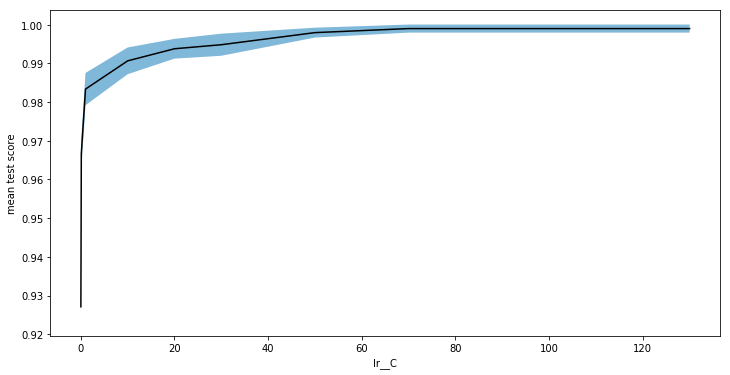

In [44]:
mean_scor = grd.cv_results_['mean_test_score']
std_score = grd.cv_results_['std_test_score']
plt.figure(figsize=(12,6))
plt.plot(param, grd.cv_results_['mean_test_score'], c='k')
plt.fill_between(param, mean_scor - std_score/2, mean_scor + std_score/2, alpha=0.5)
plt.xlabel('lr__C')
plt.ylabel('mean test score')
plt.show()

Accuracy на тренировочных данных: 0.9989583333333333
Accuracy на тестовых данных: 0.975


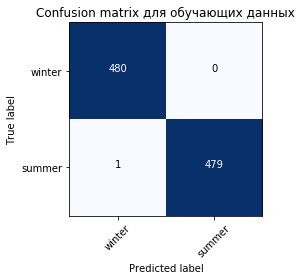

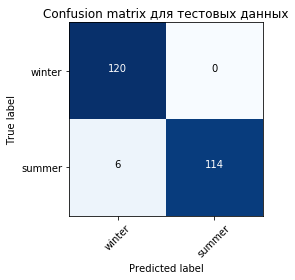

In [45]:
std = StandardScaler()
clf = LogisticRegression(C=30)
pipe = Pipeline([('std', std), ('lg', clf)])

pipe.fit(X_train, y_train)
print_metrics(pipe, X_train, X_test, y_train, y_test)

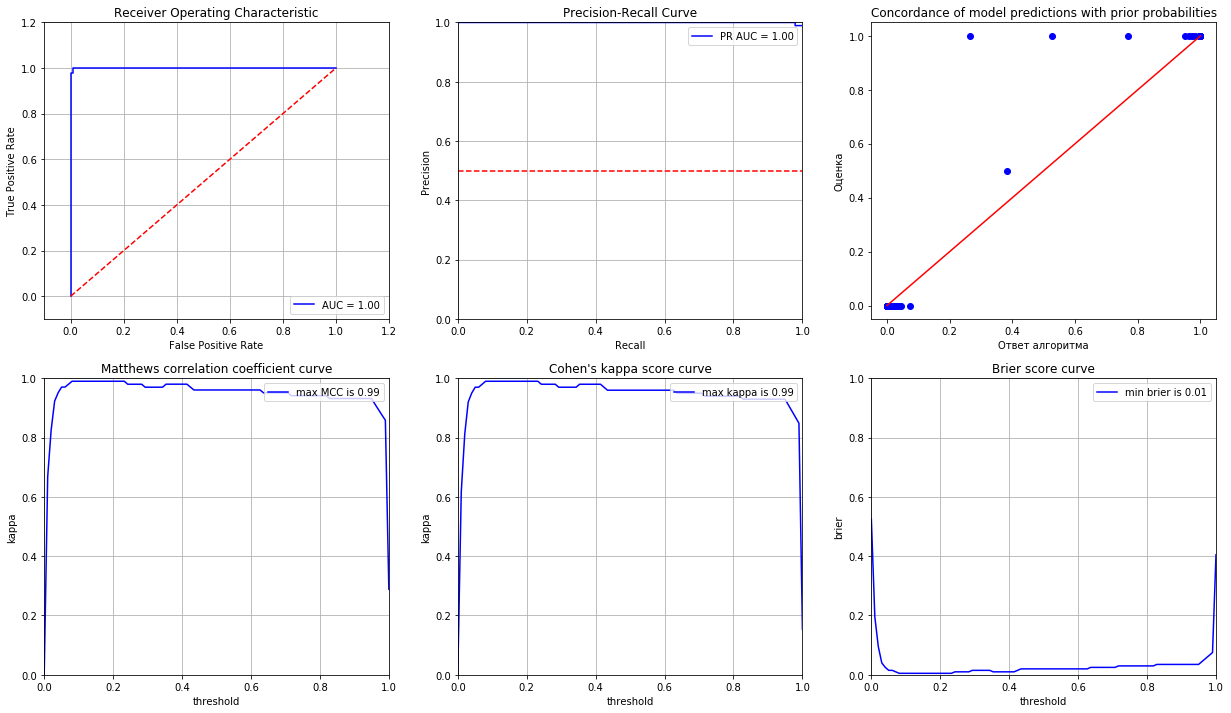

The rmse of model's prediction is: 0.1038
The Gini of model's prediction is: 0.9996
The ROC AUC of model's prediction is: 0.9998
The PR AUC of model's prediction is: 0.9998
Max Cohen's kappa is 0.990 with threshold = 0.08
Max Matthews correlation coefficient is 0.990 with threshold = 0.08
Min Brier score is 0.005 with threshold = 0.08


In [46]:
pr_prob = pipe.predict_proba(X_test)[:,1]
N = len(y_test)
M = 100
n = int(N/M)
plot_metrics(np.array(y_test[:n*M]), pr_prob[:n*M],n=M)

## LogisticRegression + PCA

**Зависимость точности классификации от числа компонент**

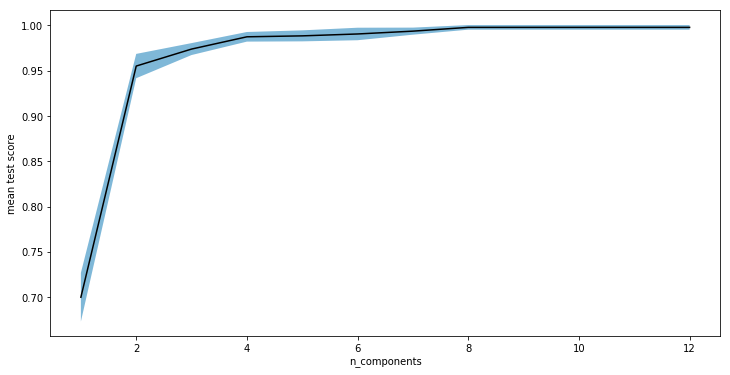

In [47]:
pca = PCA()
clf = LogisticRegression(C=1)
pipe = Pipeline([('pca', pca), ('lg', clf)])

param = list(range(1,N_cord+1))
param_grid = { 'pca__n_components': param }

grd = GridSearchCV(pipe, param_grid, cv=5,
                      return_train_score=False)

grd.fit(X_train, y_train)

mean_scor = grd.cv_results_['mean_test_score']
std_score = grd.cv_results_['std_test_score']
plt.figure(figsize=(12,6))
plt.plot(param, grd.cv_results_['mean_test_score'], c='k')
plt.fill_between(param, mean_scor - std_score, mean_scor + std_score, alpha=0.5)
plt.xlabel('n_components')
plt.ylabel('mean test score')
plt.show()

Accuracy на тренировочных данных: 0.9989583333333333
Accuracy на тестовых данных: 0.975


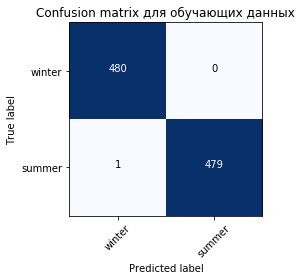

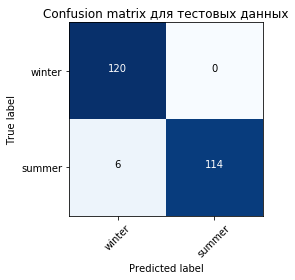

In [48]:
pca = PCA(n_components=10)
clf = LogisticRegression()
pipe = Pipeline([('pca', pca), ('lg', clf)])
pipe.fit(X_train, y_train)
print_metrics(pipe, X_train, X_test, y_train, y_test)

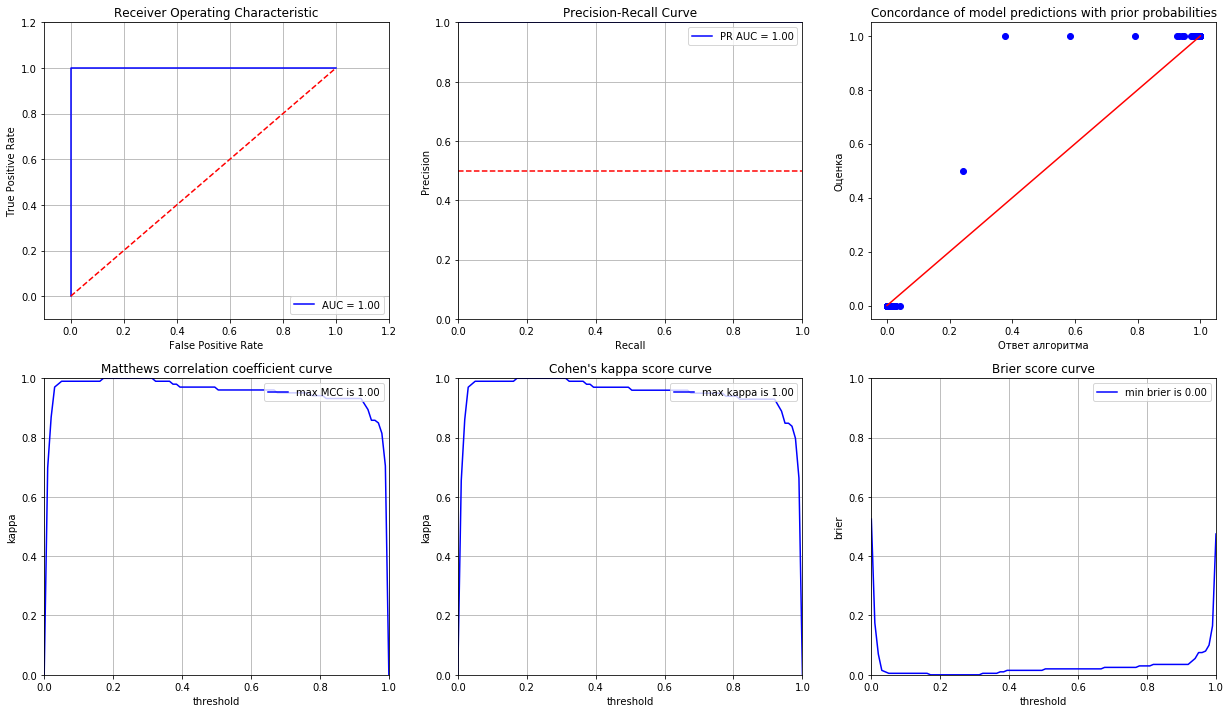

The rmse of model's prediction is: 0.0940
The Gini of model's prediction is: 1.0000
The ROC AUC of model's prediction is: 1.0000
The PR AUC of model's prediction is: 1.0000
Max Cohen's kappa is 1.000 with threshold = 0.17
Max Matthews correlation coefficient is 1.000 with threshold = 0.17
Min Brier score is 0.000 with threshold = 0.17


In [49]:
pr_prob = pipe.predict_proba(X_test)[:,1]
N = len(y_test)
M = 100
n = int(N/M)
plot_metrics(np.array(y_test[:n*M]), pr_prob[:n*M],n=M)

## Сравнение алгоритмов сжатия

In [29]:
researcher_pca(LogisticRegression, X_train, y_train, X_test, y_test)

[0.9625, 0.9666666666666667, 0.9666666666666667, 0.975]

In [30]:
researcher_ksvd(LogisticRegression, X_train, y_train, X_test, y_test)

[0.85, 0.9625, 0.9666666666666667, 0.9666666666666667]

In [31]:
researcher_ae(LogisticRegression, X_train, y_train, X_test, y_test)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


[0.8958333333333334, 0.95, 0.9583333333333334, 0.9583333333333334]

## RandomForestClassifier

In [50]:
clf = RandomForestClassifier()
param_grid = { 'n_estimators': [1, 5, 10, 20, 50, 75, 100, 150, 200, 300, 400, 500], 'min_samples_split' : [2, 3, 4] }

grd = GridSearchCV(clf, param_grid, cv=5,
                      return_train_score=False)
grd.fit(X_train, y_train)
grd.best_params_

{'min_samples_split': 3, 'n_estimators': 50}

In [60]:
clf = RandomForestClassifier(n_estimators=50,min_samples_split=3)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Accuracy на тренировочных данных: 1.0
Accuracy на тестовых данных: 0.9791666666666666


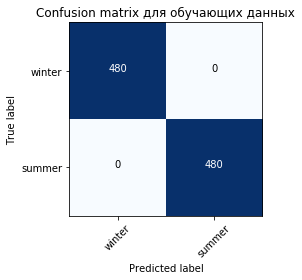

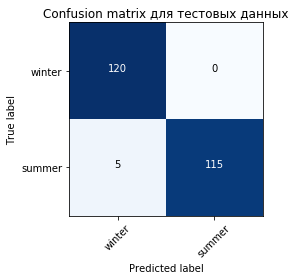

In [61]:
print_metrics(clf, X_train, X_test, y_train, y_test)

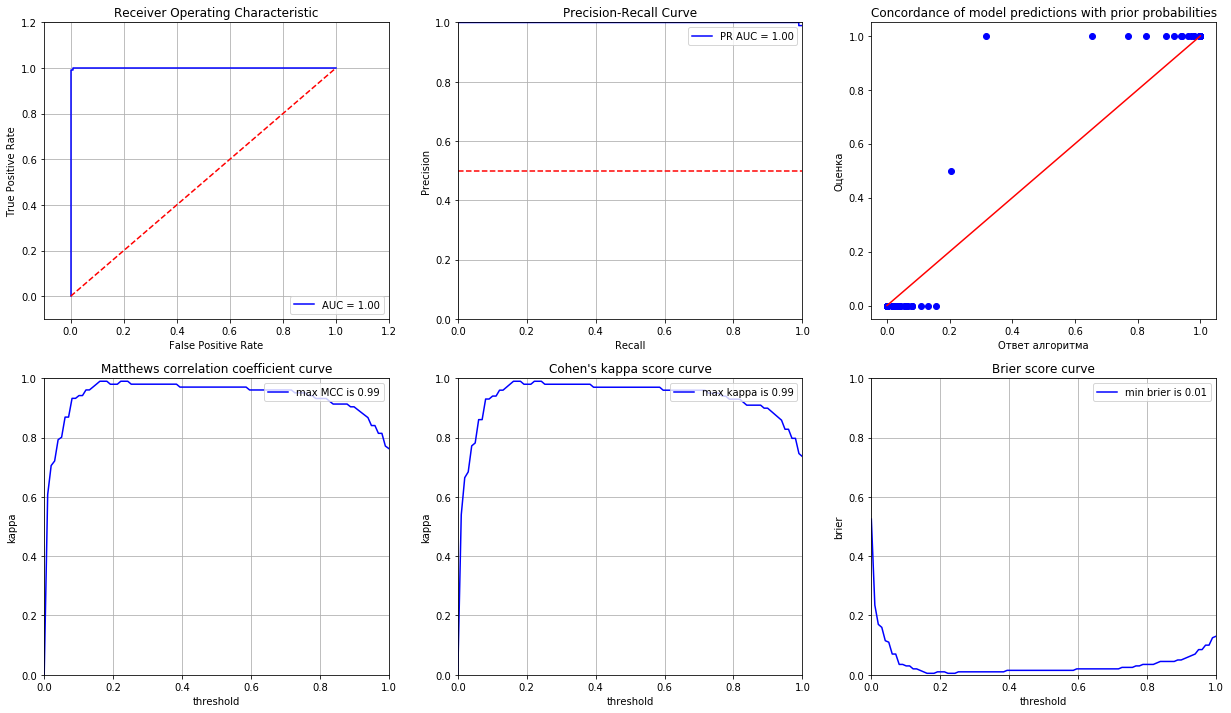

The rmse of model's prediction is: 0.1079
The Gini of model's prediction is: 0.9998
The ROC AUC of model's prediction is: 0.9999
The PR AUC of model's prediction is: 0.9999
Max Cohen's kappa is 0.990 with threshold = 0.16
Max Matthews correlation coefficient is 0.990 with threshold = 0.16
Min Brier score is 0.005 with threshold = 0.16


In [53]:
pr_prob = clf.predict_proba(X_test)[:,1]
N = len(y_test)
M = 100
n = int(N/M)
plot_metrics(np.array(y_test[:n*M]), pr_prob[:n*M],n=M)

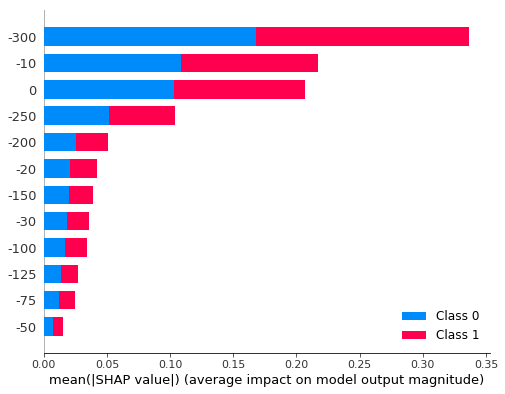

In [58]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

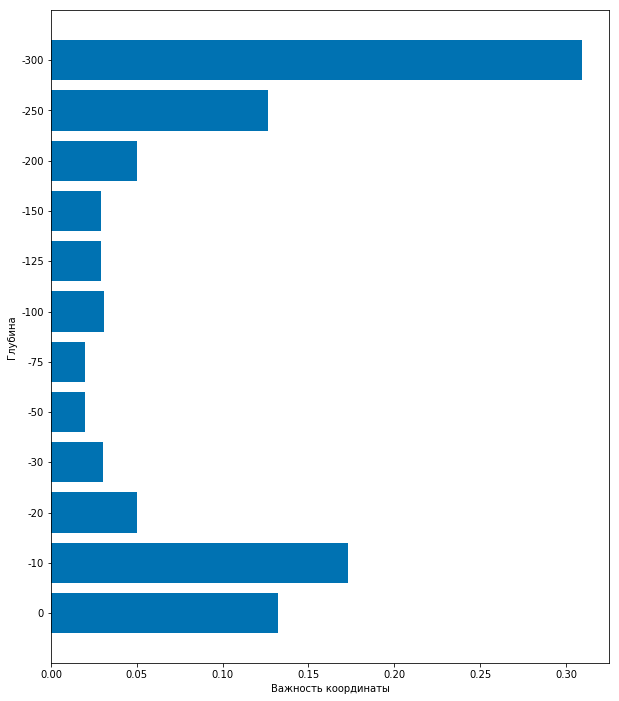

In [54]:
feature_importances(clf)

In [57]:
researcher_pca(RandomForestClassifier, X_train, y_train, X_test, y_test)

[0.9678571428571429,
 0.9916666666666667,
 0.9988095238095238,
 0.9988095238095238]

In [58]:
researcher_ksvd(RandomForestClassifier, X_train, y_train, X_test, y_test)

[0.8369047619047619,
 0.9773809523809524,
 0.9928571428571429,
 0.9940476190476191]

In [60]:
researcher_ae(RandomForestClassifier, X_train, y_train, X_test, y_test)

[0.75595238095238093,
 0.93095238095238098,
 0.94880952380952377,
 0.96309523809523812,
 0.98095238095238091]

## Бустинг

In [30]:
n_est = [100, 200, 500,700, 1000]
max_dep = [1,2,3]
lr = [0.01, 0.1, 0.5, 1]
clf = XGBClassifier()
param_grid = { 'n_estimators': n_est, 'max_depth':max_dep, 'learning_rate':lr}

grd = GridSearchCV(clf, param_grid, cv=5,
                      return_train_score=False)
grd.fit(np.array(X_train), y_train)
grd.best_params_

{'learning_rate': 1, 'max_depth': 3, 'n_estimators': 200}

Accuracy на тренировочных данных: 1.0
Accuracy на тестовых данных: 0.9791666666666666


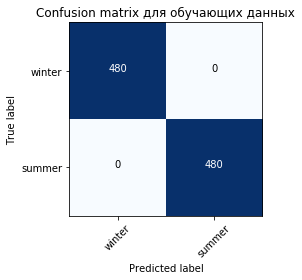

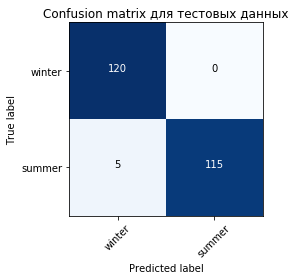

In [31]:
clf = XGBClassifier(learning_rate=1, max_depth=3, n_estimators=200)
clf.fit(np.array(X_train), y_train)
print_metrics(clf, np.array(X_train), np.array(X_test), y_train, y_test)
xgb_acc = accuracy_score(y_test, clf.predict(np.array(X_test)))

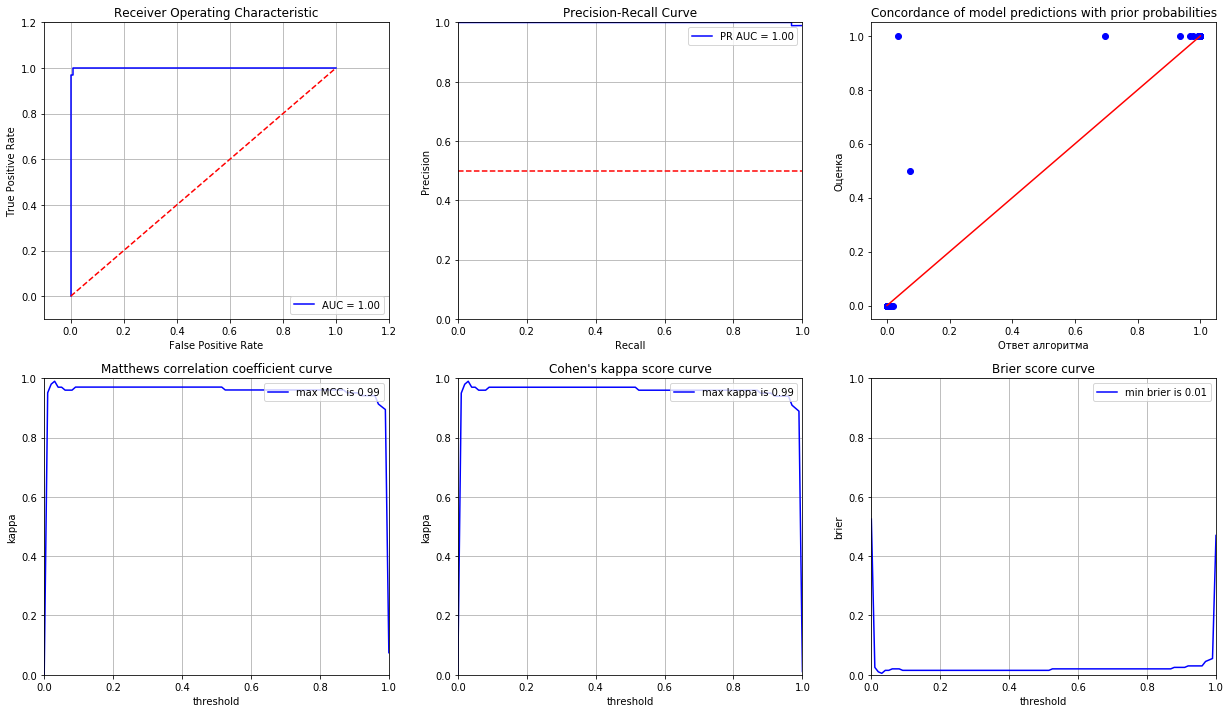

The rmse of model's prediction is: 0.1228
The Gini of model's prediction is: 0.9994
The ROC AUC of model's prediction is: 0.9997
The PR AUC of model's prediction is: 0.9997
Max Cohen's kappa is 0.990 with threshold = 0.03
Max Matthews correlation coefficient is 0.990 with threshold = 0.03
Min Brier score is 0.005 with threshold = 0.03


In [13]:
pr_prob = clf.predict_proba(np.array(X_test))[:,1]
N = len(y_test)
M = 100
n = int(N/M)
plot_metrics(np.array(y_test[:n*M]), pr_prob[:n*M],n=M)

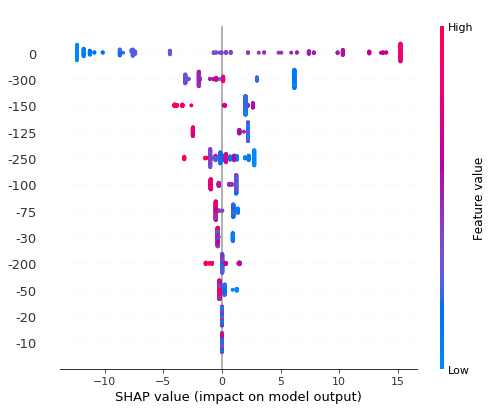

In [68]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

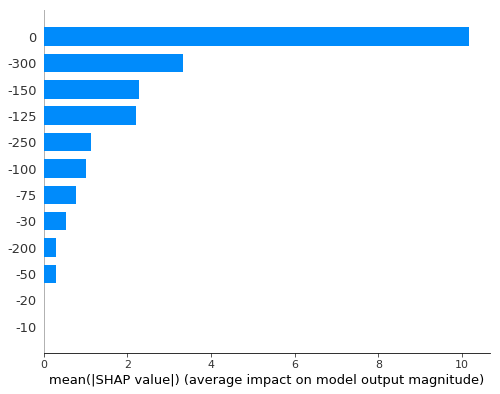

In [69]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

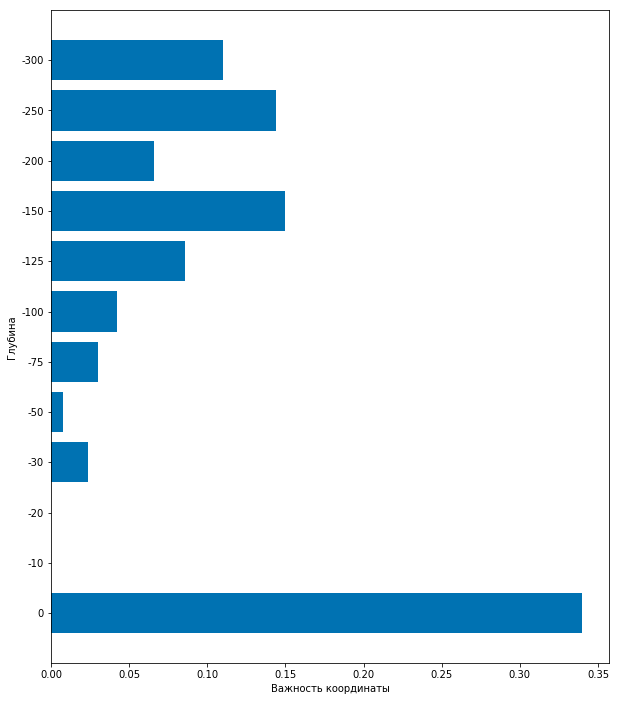

In [39]:
feature_importances(clf)

## Качество классификации при снижении размерности

In [32]:
score_pca = researcher_pca(XGBClassifier, X_train, y_train, X_test, y_test, n_estimators=500, n_comp=[2,3,5,7,10,12])
score_pca

[0.9458333333333333,
 0.9708333333333333,
 0.9833333333333333,
 0.9875,
 0.9833333333333333,
 0.9875]

In [33]:
score_kmeans = researcher_kmeans(XGBClassifier, X_train.values, y_train, X_test.values, y_test,n_estimators=500, n_comp=[2,3,5,7,10,11])
score_kmeans

[0.7208333333333333,
 0.6416666666666667,
 0.7625,
 0.7666666666666667,
 0.8416666666666667,
 0.8416666666666667]

In [34]:
score_ksvd = researcher_ksvd(XGBClassifier, X_train.values, y_train, X_test.values, y_test, k=2, n_estimators=500, n_comp=[2,3,5,7,10,11])
score_ksvd

[0.825,
 0.85,
 0.975,
 0.9833333333333333,
 0.9791666666666666,
 0.9833333333333333]

In [35]:
score_ae = researcher_ae(XGBClassifier, X_train.values, y_train, X_test.values, y_test, n_estimators=500, n_units=[2,3,5,7,10,12])
score_ae

[0.9416666666666667,
 0.9666666666666667,
 0.975,
 0.975,
 0.9791666666666666,
 0.9916666666666667]

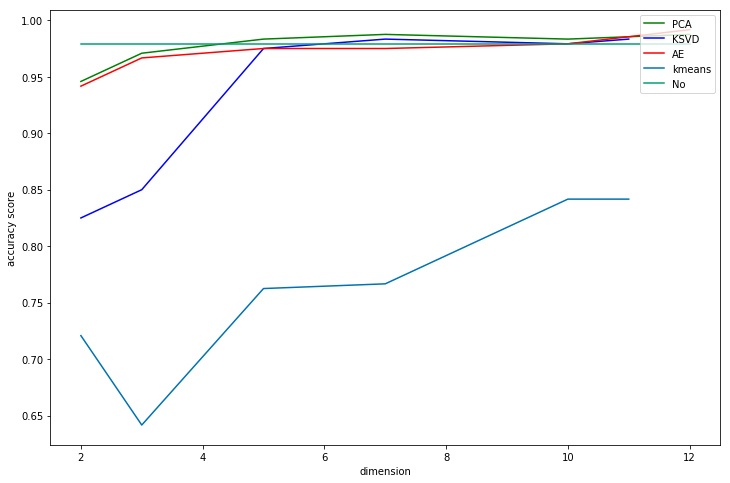

In [36]:
plt.figure(figsize=(12,8))
plt.plot([2,3,5,7,10,12], score_pca, 'g', [2,3,5,7,10,11], score_ksvd, 'b',
         [2,3,5,7,10,12], score_ae, 'r', [2,3,5,7,10,11], score_kmeans, [2,12], [xgb_acc,xgb_acc])
plt.legend(('PCA', 'KSVD', 'AE', 'kmeans', 'No'),
           loc='upper right')
plt.xlabel('dimension')
plt.ylabel('accuracy score')
plt.show()

**подробнее про k-svd**

In [98]:
Score_ksvd = []
for k in range(0, 11, 2):
    score_ksvd = researcher_ksvd(XGBClassifier, X_train.values, y_train, X_test.values, y_test, k=k, n_estimators=500, n_comp=[2,3,5,7,10,11])
    Score_ksvd.append(score_ksvd)

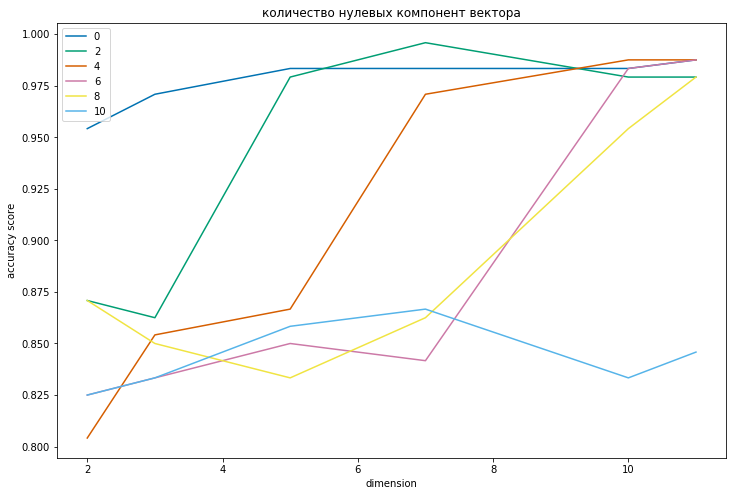

In [101]:
plt.figure(figsize=(12,8))
for score in Score_ksvd:
    plt.plot([2,3,5,7,10,11], score)
plt.legend(tuple([str(i) for i in range(0,11, 2)]),
           loc='upper left')

plt.title('количество нулевых компонент вектора')
plt.xlabel('dimension')
plt.ylabel('accuracy score')
plt.show()

In [ ]:
## Важность базисных компонент разложения

**pca**

In [35]:
pca = PCA(n_components=len(zs))
pca.fit(X_train)
x_coef = pca.transform(X_train)
x_coef = pd.DataFrame(x_coef, columns = ['component {0}'.format(i) for i in range(1,len(zs)+1)])

In [36]:
clf = XGBClassifier(n_estimators=500)
clf.fit(x_coef,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

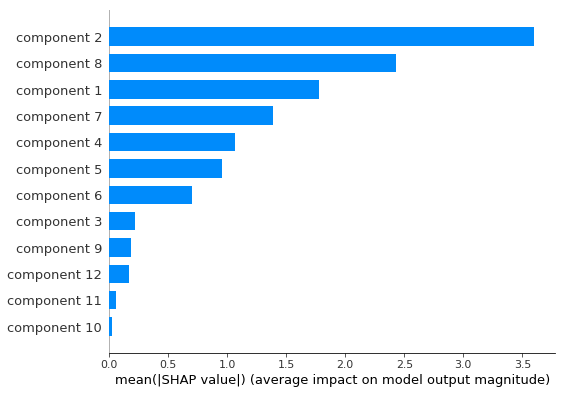

In [37]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(x_coef)
shap.summary_plot(shap_values, x_coef, plot_type = "bar")

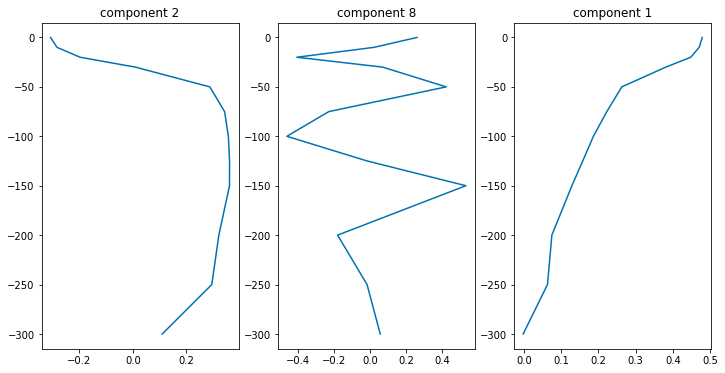

In [38]:
best_comp = [2,8,1]
n = len(best_comp)
comp = pca.components_
i=1
plt.figure(figsize=(12,6))
for bc in best_comp:
    plt.subplot(1,n, i)
    plt.plot(comp[bc-1,:],zs)
    plt.title('component {0}'.format(bc))
    i+=1
plt.show()

**ksvd**

In [39]:
ksvd = ApproximateKSVD(n_components=11, transform_n_nonzero_coefs=9)
meantr = np.mean(np.array(X_train),axis=0)
ksvd.fit(np.array(X_train) - meantr).components_
gamma_train = ksvd.transform(np.array(X_train) - meantr)
gamma_test = ksvd.transform(np.array(X_test) - meantr)

In [40]:
x_coef = pd.DataFrame(gamma_train, columns = ['component {0}'.format(i) for i in range(1,len(zs))])

In [41]:
clf = XGBClassifier(n_estimators=500)
clf.fit(x_coef,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

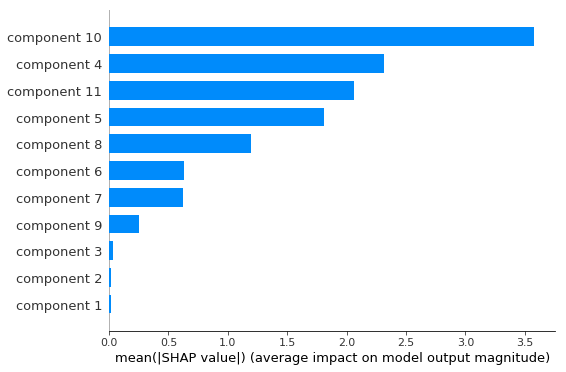

In [42]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(x_coef)
shap.summary_plot(shap_values, x_coef, plot_type = "bar")

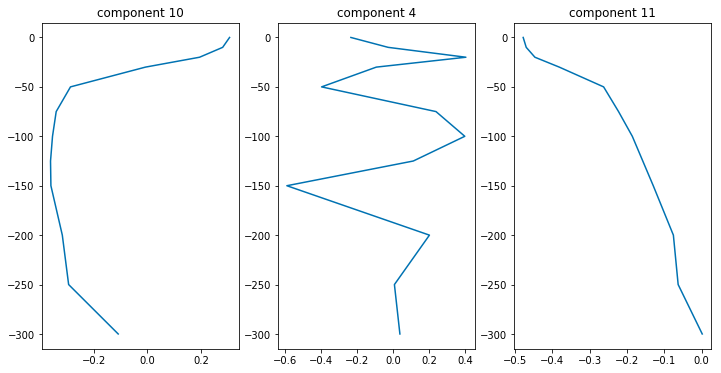

In [44]:
best_comp = [10,4,11]
n = len(best_comp)
comp = ksvd.components_
i=1
plt.figure(figsize=(12,6))
for bc in best_comp:
    plt.subplot(1,n, i)
    plt.plot(comp[bc-1,:],zs)
    plt.title('component {0}'.format(bc))
    i+=1
plt.show()

## Визуализация зима/лето

In [117]:
win_data = np.array([X.values[i] for i in range(len(X)) if Y[i] == 0])
sum_data = np.array([X.values[i] for i in range(len(X)) if Y[i] == 1])

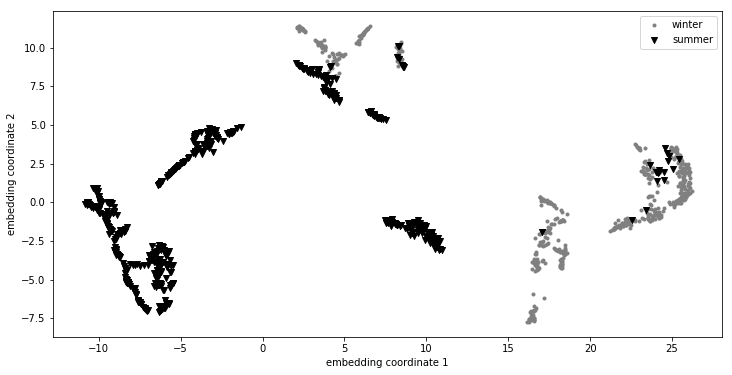

In [118]:
embedding = umap.UMAP()
embedding.fit(X)
win_emb = embedding.transform(win_data)
sum_emb = embedding.transform(sum_data)
plt.figure(figsize=(12,6))
plt.scatter(win_emb[:,0], win_emb[:,1], c = 'grey', label='winter', marker = ".")
plt.scatter(sum_emb[:,0], sum_emb[:,1], c = 'black', label = 'summer',marker =  "v")
plt.xlabel('embedding coordinate 1')
plt.ylabel('embedding coordinate 2')
plt.legend()
plt.show()

**визуальная разделимость от колличества  компонент PCA**

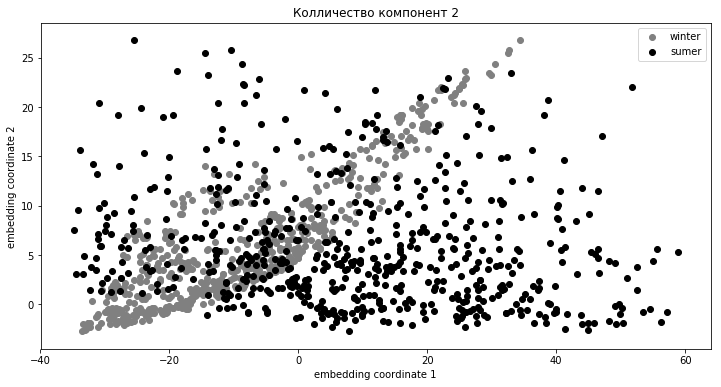

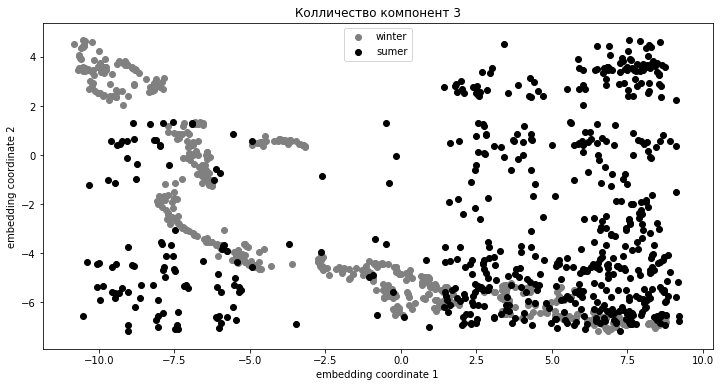

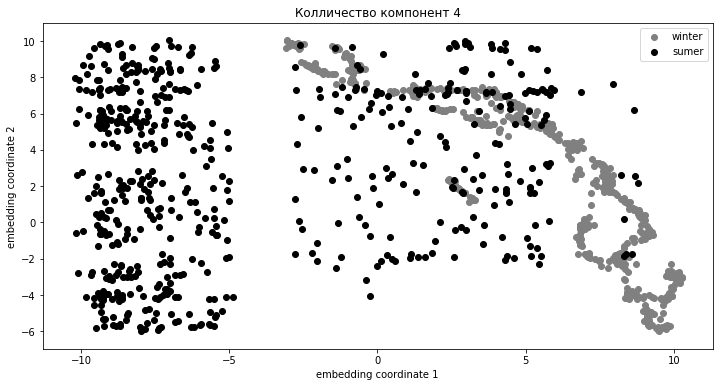

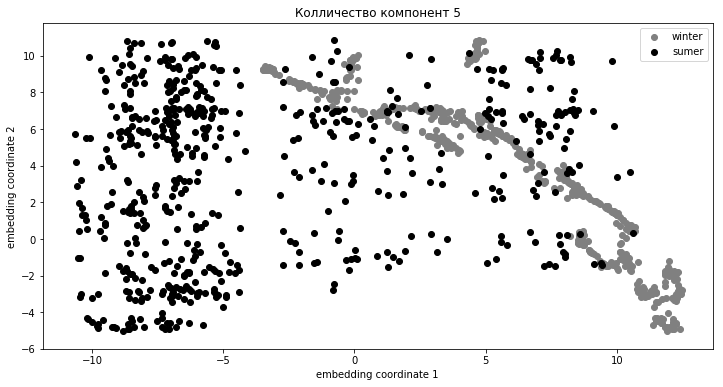

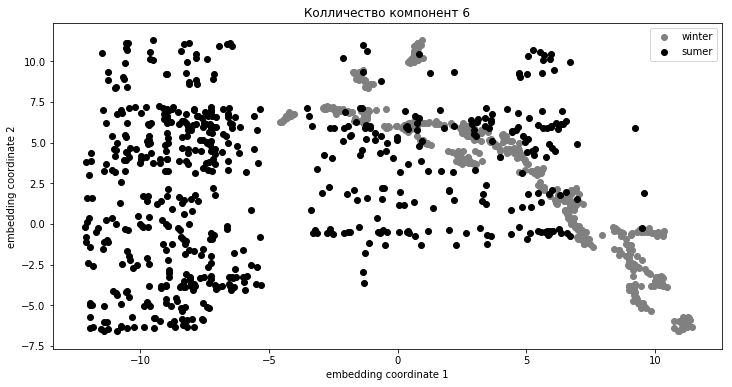

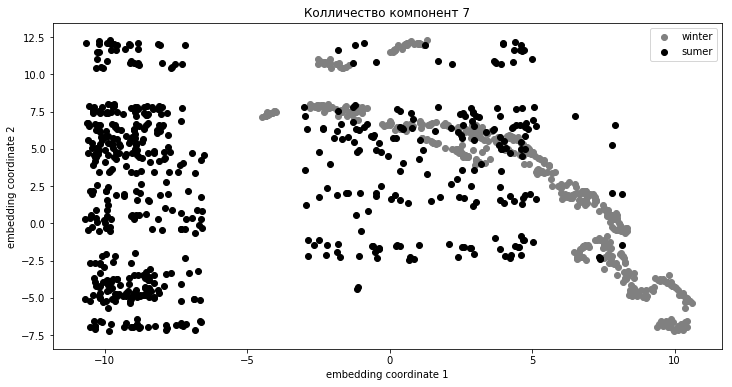

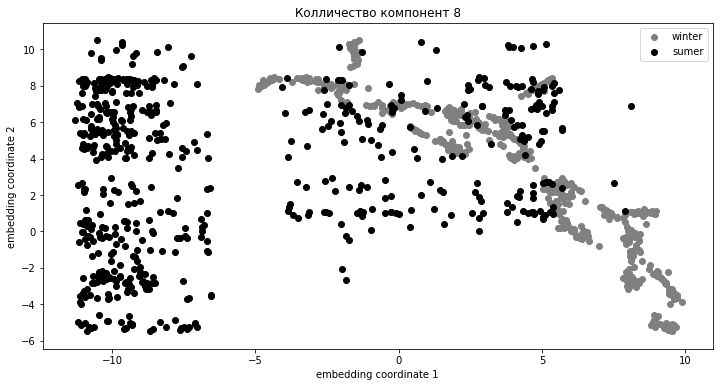

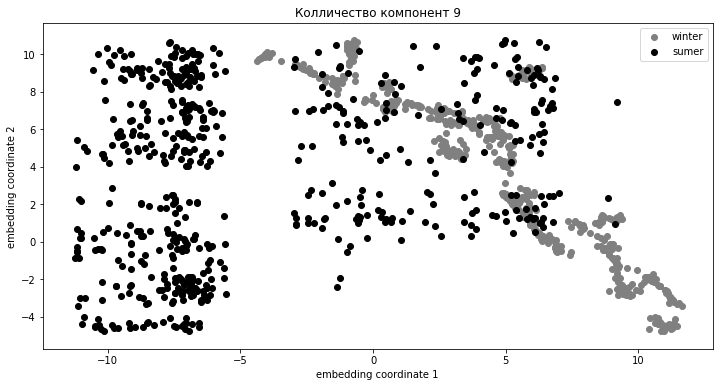

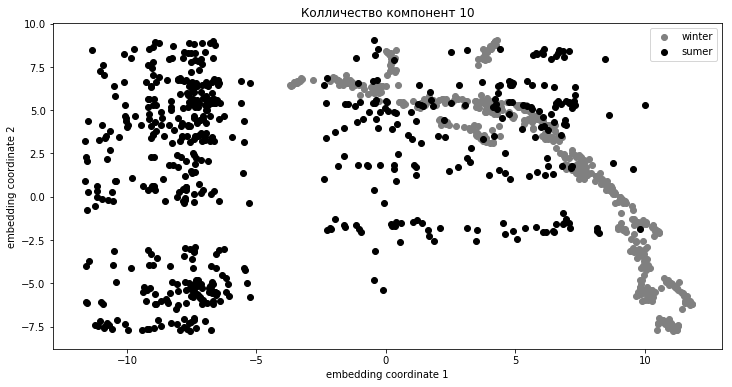

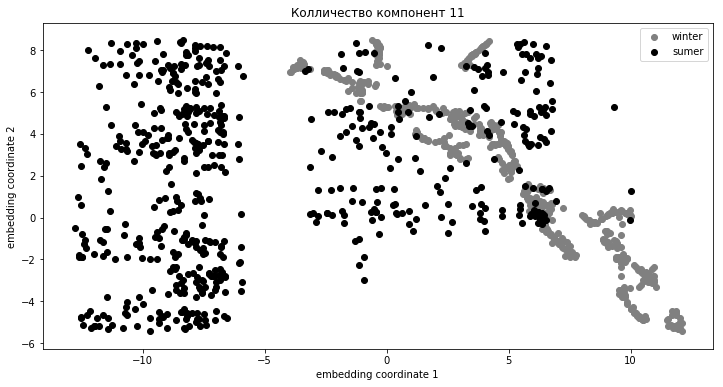

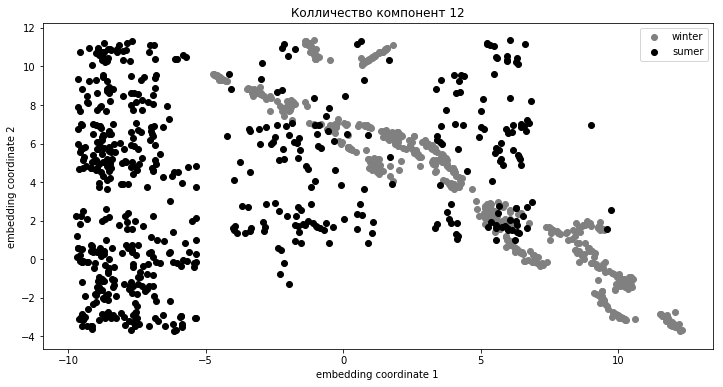

In [121]:
for n_comp in range(2,13):
    pca = PCA(n_components=n_comp)
    AllX_red = pca.fit_transform(X)
    embedding.fit(AllX_red)
    plt.figure(figsize=(12,6))
    if n_comp == 2:
        win_emb = pca.transform(win_data)
        sum_emb = pca.transform(sum_data)
    else:
        win_emb = embedding.transform(pca.transform(win_data))
        sum_emb = embedding.transform(pca.transform(sum_data))
    plt.scatter(win_emb[:,0], win_emb[:,1], label='winter', c='grey')
    plt.scatter(sum_emb[:,0], win_emb[:,1], label='sumer', c='black')
    plt.title("Колличество компонент {}".format(n_comp))
    plt.legend()
    plt.xlabel('embedding coordinate 1')
    plt.ylabel('embedding coordinate 2')
    plt.show()